# LoRA

LoRA, which stands for **Low-Rank Adaptation**, is a popular technique to *finetune LLMs more efficiently*.

Instead of adjusting all the parameters of a deep neural network, **LoRA focuses on updating only a small set of low-rank matrices.**

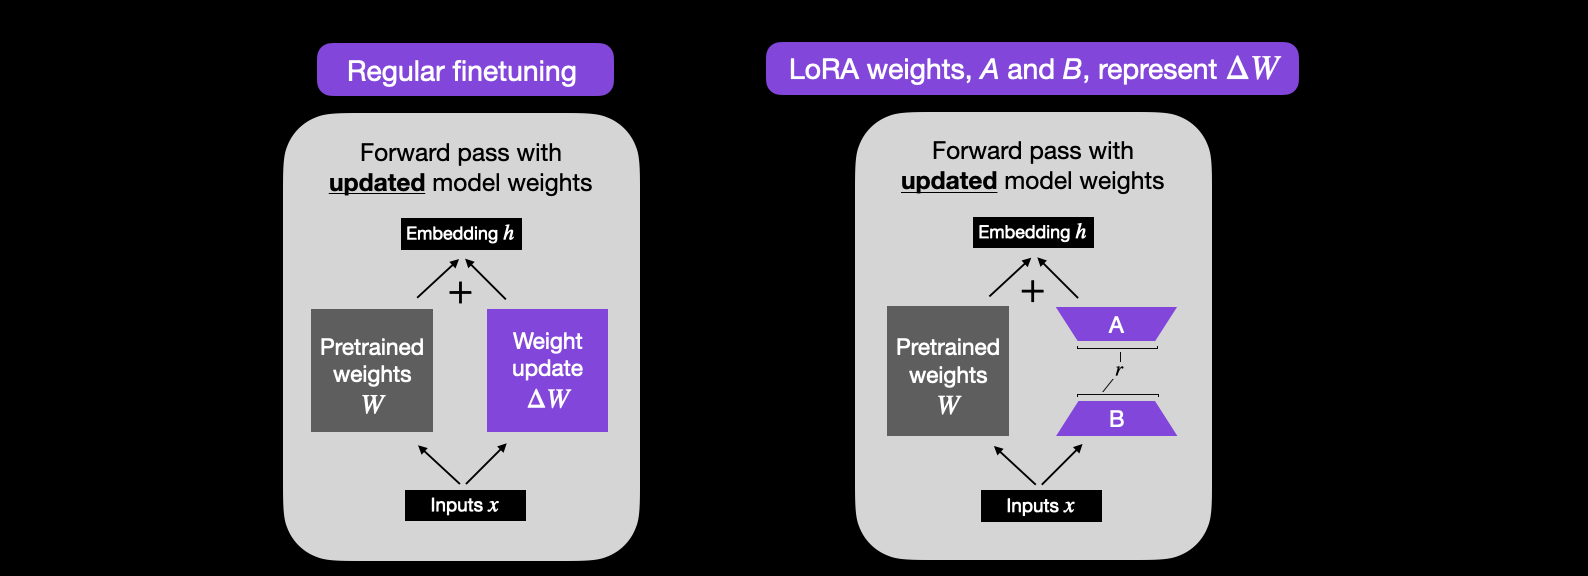

> Note that `r`, in the figure above, is a **hyperparameter** here that we can use to ***specify the rank of the low-rank matrices used for adaptation***.

> A *`smaller r` leads to a simpler low-rank matrix*, which results in **fewer parameters to learn during adaptation.**

To provide a concrete example, suppose the weight matrix `W` of a given layer has a size of *5,000x10,000* (***50M parameters in total***).

If we choose a **rank r=8**, we initialize two matrices:

the `5,000x8-dimensional matrix B` and

the `8x10,000-dimensional matrix A`.

Added together, **A and B have only 80,000 + 40,000 = 120,000 parameters**, which is ***400 times smaller than the 50M parameters*** in regular finetuning via `ΔW`.

In [ ]:
import time
import numpy as np
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch.nn as nn
import torch


if torch.cuda.is_available():
  torch.backends.cudnn.deterministic = True

In [ ]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 64

train_dataset = datasets.MNIST(root='data',
                               train=True,
                               transform=transforms.ToTensor(),
                               download=True)

test_dataset = datasets.MNIST(root='data',
                              train=False,
                              transform=transforms.ToTensor())


train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=True)

test_loader = DataLoader(dataset=test_dataset,
                         batch_size=BATCH_SIZE,
                         shuffle=False)

# Checking the dataset
for images, labels in train_loader:
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:00<00:00, 16.1MB/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 487kB/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.46MB/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 4.54MB/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw

Image batch dimensions: torch.Size([64, 1, 28, 28])
Image label dimensions: torch.Size([64])


## Multilayer Perceptron Model (Without LoRA and DoRA)

In [ ]:
# Hyperparameters
random_seed = 123
learning_rate = 0.005
num_epochs = 2

# Architecture
num_features = 784
num_hidden_1 = 128
num_hidden_2 = 256
num_classes = 10

In [ ]:
class MultiLayerPerceptron(nn.Module):
  def __init__(self, num_features, num_hidden_1, num_hidden_2, num_classes):
    super().__init__()

    self.layers = nn.Sequential(
        nn.Linear(num_features, num_hidden_1),
        nn.ReLU(),
        nn.Linear(num_hidden_1, num_hidden_2),
        nn.ReLU(),
        nn.Linear(num_hidden_2, num_classes)
    )

  def forward(self, x):
    x = self.layers(x)
    return x

In [ ]:
torch.manual_seed(random_seed)
model_pretrained = MultiLayerPerceptron(
    num_features=num_features,
    num_hidden_1=num_hidden_1,
    num_hidden_2=num_hidden_2,
    num_classes=num_classes
)

model_pretrained.to(DEVICE)
optimizer_pretrained = torch.optim.Adam(model_pretrained.parameters(), lr=learning_rate)

In [ ]:
def compute_accuracy(model, data_loader , device):
  model.eval()
  correct_pred, num_examples = 0, 0

  with torch.no_grad():
    for features, targets in data_loader:
      features = features.view(-1, 28*28).to(device)
      targets = targets.to(device)
      logits = model(features)
      _, predicted_labels = torch.max(logits, 1)
      num_examples += targets.size(0)
      correct_pred += (predicted_labels == targets).sum()

    return correct_pred.float() / num_examples * 100

In [ ]:
def train(num_epochs, model, optimizer, train_loader, device):

    start_time = time.time()
    for epoch in range(num_epochs):
        model.train()
        for batch_idx, (features, targets) in enumerate(train_loader):

            features = features.view(-1, 28*28).to(device)
            targets = targets.to(device)

            # FORWARD AND BACK PROP
            logits = model(features)
            loss = F.cross_entropy(logits, targets)
            optimizer.zero_grad()

            loss.backward()

            # UPDATE MODEL PARAMETERS
            optimizer.step()

            # LOGGING
            if not batch_idx % 400:
                print('Epoch: %03d/%03d | Batch %03d/%03d | Loss: %.4f'
                      % (epoch+1, num_epochs, batch_idx,
                          len(train_loader), loss))

        with torch.set_grad_enabled(False):
            print('Epoch: %03d/%03d training accuracy: %.2f%%' % (
                  epoch+1, num_epochs,
                  compute_accuracy(model, train_loader, device)))

        print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))

    print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

In [ ]:
train(num_epochs, model_pretrained, optimizer_pretrained, train_loader, DEVICE)
print(f'Test accuracy: {compute_accuracy(model_pretrained, test_loader, DEVICE):.2f}%')

Epoch: 001/002 | Batch 000/938 | Loss: 2.2971
Epoch: 001/002 | Batch 400/938 | Loss: 0.1529
Epoch: 001/002 | Batch 800/938 | Loss: 0.1094
Epoch: 001/002 training accuracy: 96.01%
Time elapsed: 0.25 min
Epoch: 002/002 | Batch 000/938 | Loss: 0.1192
Epoch: 002/002 | Batch 400/938 | Loss: 0.0593
Epoch: 002/002 | Batch 800/938 | Loss: 0.0806
Epoch: 002/002 training accuracy: 97.23%
Time elapsed: 0.51 min
Total Training Time: 0.51 min
Test accuracy: 96.73%


## Multilayer Perceptron with LoRA and DoRA

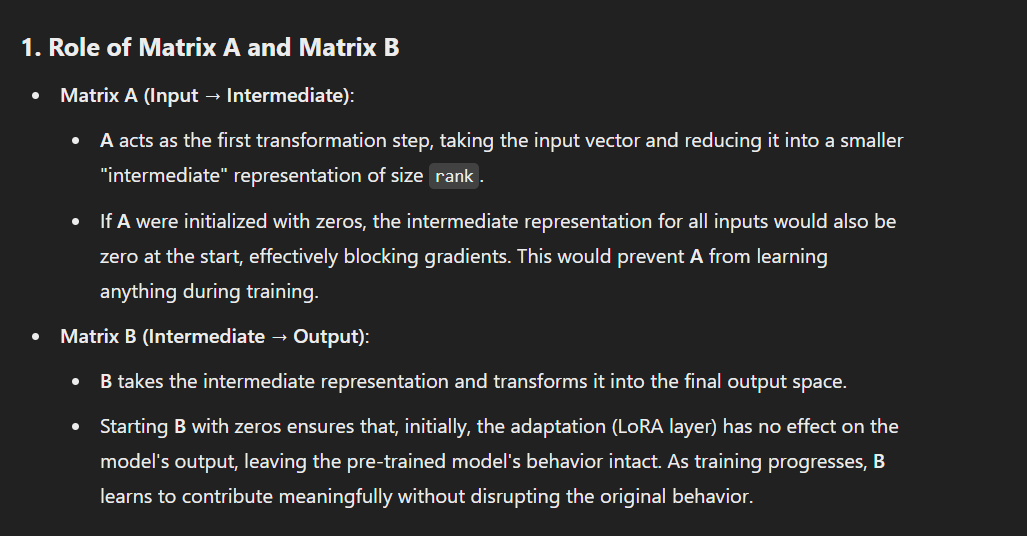

We previously discussed that the `rank` of the matrices `A` and `B` is a **hyperparameter** that ***controls the complexity and the number of additional parameters introduced by `LoRA`.***

However, looking at the code, we added another hyperparameter,

the **`scaling factor alpha`**.

This factor determines **the magnitude of the changes introduced by the LoRA layer to the model's existing weights**: `alpha * (x @ A @ B)`.

A **higher value of alpha means larger adjustments** to the model's behavior, while a lower value results in more subtle changes.

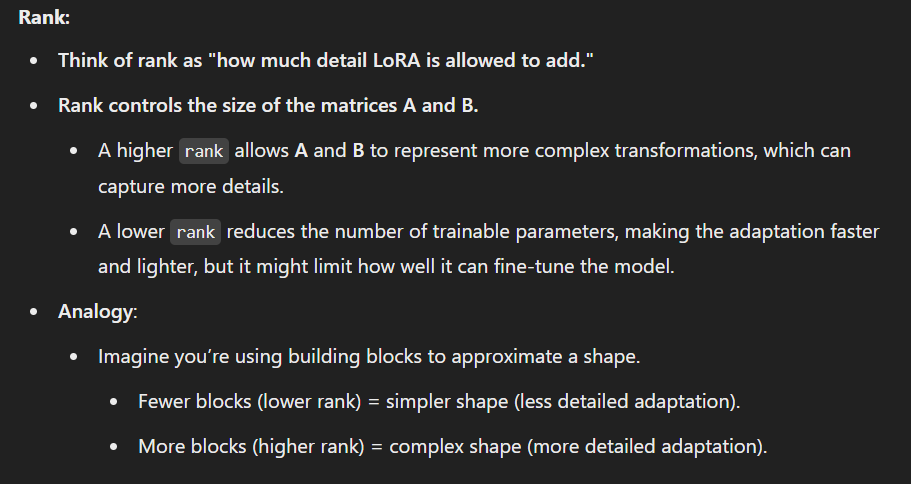

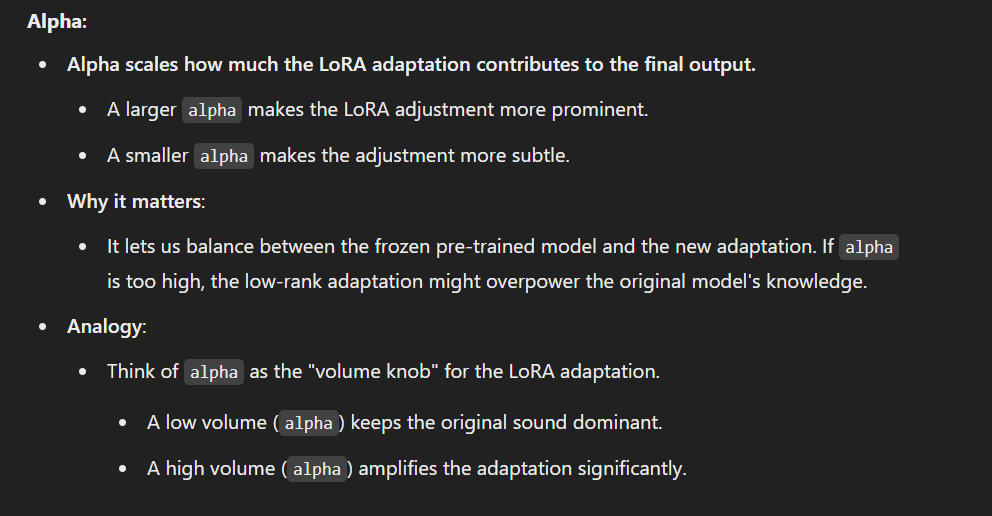

In [ ]:
class LoRALayer(nn.Module):
  def __init__(self, in_dim, out_dim, rank, alpha):
    super().__init__()
    std_dev = 1 / torch.sqrt(torch.tensor(rank).float())

    self.A = nn.Parameter(torch.randn(in_dim, rank) * std_dev)
    self.B = nn.Parameter(torch.zeros(rank, out_dim))
    self.alpha = alpha

  def forward(self, x):
    x = self.alpha * (x @ self.A @ self.B)
    return x

Note that `LoRA` is usually applied to a n**eural network's linear (feedforward) layers**.

For example, suppose we have a simple PyTorch model or module with two linear layers (e.g., this could be the **feedforward** module of a **transformer block**). And suppose this module's forward method looks like as follows:
```
def forward(self, x):
    x = self.linear_1(x)
    x = F.relu(x)
    x = self.linear_2(x)
    return x
```

If we use **`LoRA`**, we'd **add the LoRA updates to these linear layer outputs** as follows:



```
def forward(self, x):
    x = self.linear_1(x) + self.lora_1(x)
    x = F.relu(x)
    x = self.linear_2(x) + self.lora_2(x)
    return logits
```

In code, when implementing **`LoRA`** by modifying existing PyTorch models,

an easy way to implement such a **LoRA-modification of the linear layers** is to **replace each Linear layer with a `LinearWithLoRA` layer**

that **combines the `Linear` layer with our previous `LoRALayer` implementation.**

In [ ]:
class LinearWithLoRA(nn.Module):
  def __init__(self, linear, rank, alpha):
    super().__init__()
    self.linear = linear
    self.lora = LoRALayer(
        linear.in_features, linear.out_features, rank, alpha
    )

  def forward(self, x):
    return self.linear(x) + self.lora(x)

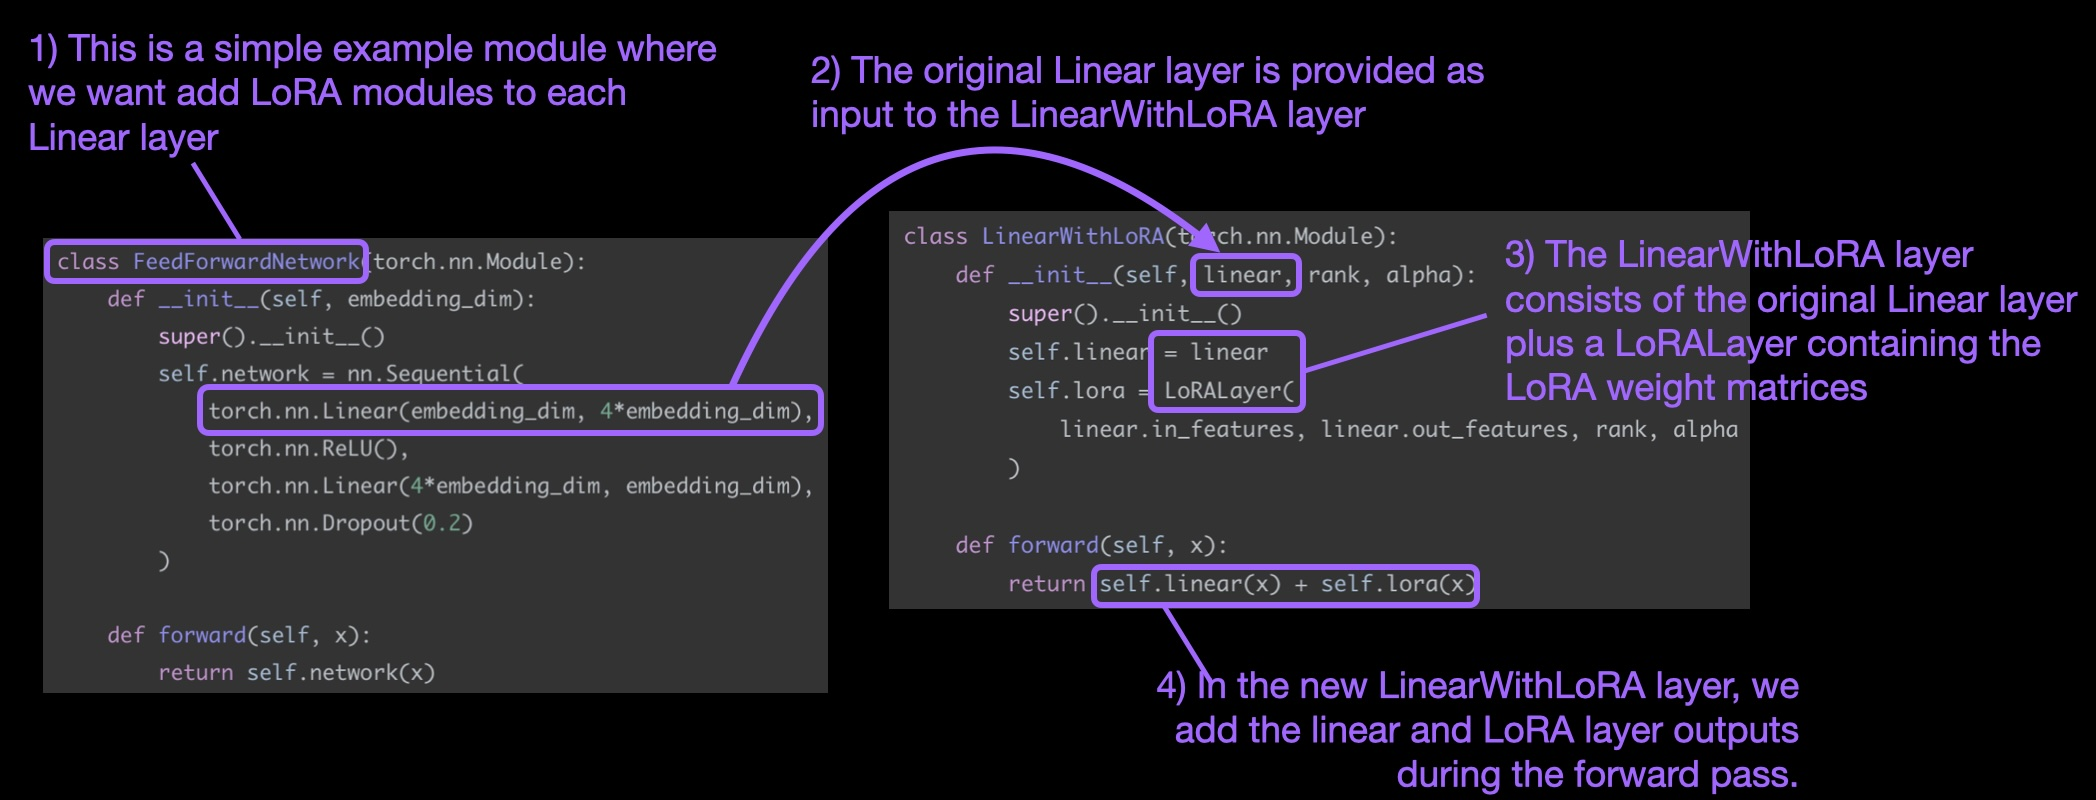

In [ ]:
x = torch.randn((1, 10))
x

tensor([[ 0.3393,  0.7483,  2.3984,  0.4536, -0.2942,  0.6014,  1.0083, -0.6951,
          0.0826,  1.0762]])

In [ ]:
torch.manual_seed(123)

layer = nn.Linear(10, 2)
x = torch.randn((1, 10))

print("Original output:", layer(x))

Original output: tensor([[0.6639, 0.4487]], grad_fn=<AddmmBackward0>)


In [ ]:
layer_lora_1 = LinearWithLoRA(layer, rank=2, alpha=4)

print("LoRA output:", layer_lora_1(x))

LoRA output: tensor([[0.6639, 0.4487]], grad_fn=<AddBackward0>)


In regular training and finetuning, the weight update is defined as follows:

`Wupdated = W + ΔW`

The LoRA method proposed by *Hu et al.* offers a more efficient alternative to computing the weight updates `ΔW` by learning an approximation of it, **`ΔW ≈ AB`**.

In other words, in LoRA, we have the following, where **`A` and `B` are two small weight matrices.**

`Wupdated = W + A.B`

- (The "." in "A.B" stands for matrix multiplication.)

For instance, if `x` is the input data, then we can write the following for regular finetuning:

*`x.(W+ΔW) = x.W + x.ΔW`*

Similarly, we can write the following for **`LoRA`**:

*`x.(W+A.B) = x.W + x.A.B  `*

In [ ]:
class LinearWithLoRAMerged(nn.Module):
    def __init__(self, linear, rank, alpha):
        super().__init__()
        self.linear = linear
        self.lora = LoRALayer(
            linear.in_features, linear.out_features, rank, alpha
        )

    def forward(self, x):
        lora = self.lora.A @ self.lora.B # Combine LoRA matrices
        # Then combine LoRA with orig. weights
        combined_weight = self.linear.weight + self.lora.alpha*lora.T
        return F.linear(x, combined_weight, self.linear.bias)

In [ ]:
layer_lora_2 = LinearWithLoRAMerged(layer, rank=2, alpha=4)
print("LoRA output:", layer_lora_2(x))

LoRA output: tensor([[0.6639, 0.4487]], grad_fn=<AddmmBackward0>)


## Applying LoRA Layers

In [ ]:
model_pretrained

MultiLayerPerceptron(
  (layers): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=10, bias=True)
  )
)

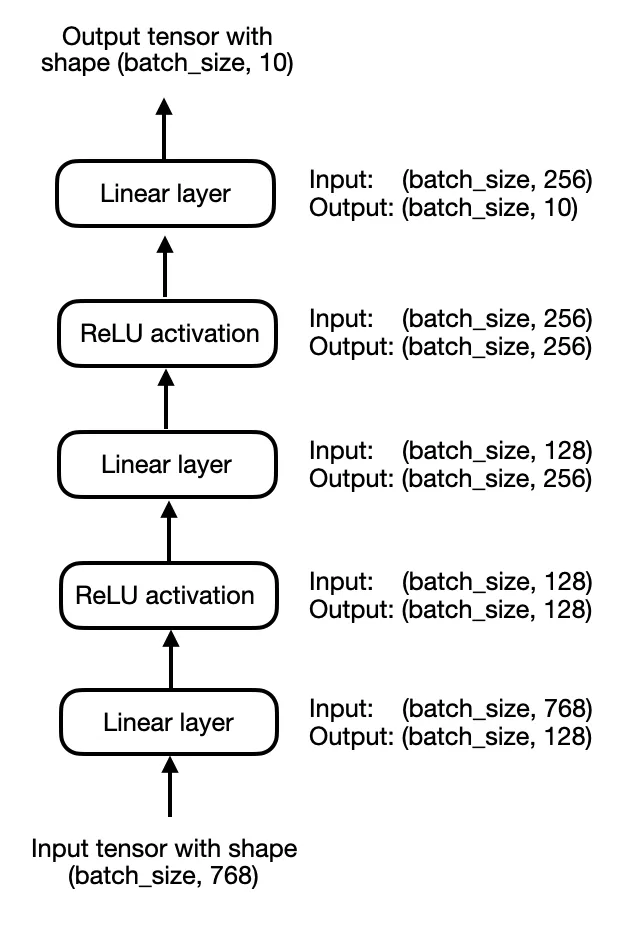

In [ ]:
import copy

In [ ]:
model_lora = copy.deepcopy(model_pretrained)

Using **`LinearWithLora`**, we can then add the **`LoRA` layers** by **replacing the original Linear layers** *italicized text* in the multilayer perceptron model.

In [ ]:
model_lora.layers[0] = LinearWithLoRA(model_lora.layers[0], rank=4, alpha=8)
model_lora.layers[2] = LinearWithLoRA(model_lora.layers[2], rank=4, alpha=8)
model_lora.layers[4] = LinearWithLoRA(model_lora.layers[4], rank=4, alpha=8)

model_lora.to(DEVICE)
optimizer_lora = torch.optim.Adam(model_lora.parameters(), lr=learning_rate)
model_lora

MultiLayerPerceptron(
  (layers): Sequential(
    (0): LinearWithLoRA(
      (linear): Linear(in_features=784, out_features=128, bias=True)
      (lora): LoRALayer()
    )
    (1): ReLU()
    (2): LinearWithLoRA(
      (linear): Linear(in_features=128, out_features=256, bias=True)
      (lora): LoRALayer()
    )
    (3): ReLU()
    (4): LinearWithLoRA(
      (linear): Linear(in_features=256, out_features=10, bias=True)
      (lora): LoRALayer()
    )
  )
)

In [ ]:
print(f'Test accuracy orig model: {compute_accuracy(model_pretrained, test_loader, DEVICE):.2f}%')
print(f'Test accuracy LoRA model: {compute_accuracy(model_lora, test_loader, DEVICE):.2f}%')

Test accuracy orig model: 96.73%
Test accuracy LoRA model: 96.73%


Then, we can **freeze the original Linear layers** and only make the **`LoRALayer` layers trainable**, as follows

In [ ]:
def freeze_linear_layers(model):
  for child in model.children():
    if isinstance(child, nn.Linear):
      for param in child.parameters():
        param.requires_grad = False

    else:
      # recursively freeze linear layers
      freeze_linear_layers(child)

In [ ]:
freeze_linear_layers(model_lora)
for name, param in model_lora.named_parameters():
  print(f"{name}: {param.requires_grad}")

layers.0.linear.weight: False
layers.0.linear.bias: False
layers.0.lora.A: True
layers.0.lora.B: True
layers.2.linear.weight: False
layers.2.linear.bias: False
layers.2.lora.A: True
layers.2.lora.B: True
layers.4.linear.weight: False
layers.4.linear.bias: False
layers.4.lora.A: True
layers.4.lora.B: True


In [ ]:
optimizer_lora = torch.optim.Adam(model_lora.parameters(), lr=learning_rate)
train(num_epochs, model_lora, optimizer_lora, train_loader, DEVICE)
print(f'Test accuracy LoRA finetune: {compute_accuracy(model_lora, test_loader, DEVICE):.2f}%')

Epoch: 001/002 | Batch 000/938 | Loss: 0.1210
Epoch: 001/002 | Batch 400/938 | Loss: 0.2014
Epoch: 001/002 | Batch 800/938 | Loss: 0.1422
Epoch: 001/002 training accuracy: 97.47%
Time elapsed: 0.27 min
Epoch: 002/002 | Batch 000/938 | Loss: 0.0776
Epoch: 002/002 | Batch 400/938 | Loss: 0.0727
Epoch: 002/002 | Batch 800/938 | Loss: 0.0063
Epoch: 002/002 training accuracy: 97.96%
Time elapsed: 0.54 min
Total Training Time: 0.54 min
Test accuracy LoRA finetune: 97.04%
